In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir


In [2]:
data_path = ['./fd-1kpc-9.6sm-0-overlaid.csv/npy0_reduced/', 'fd-1kpc-9.6sm-0-overlaid.csv/bkg_reduced_0']
file_list = []
for path_ in data_path:
    for file_ in listdir(path_):
        file_list.append(os.path.join(path_, file_))
file_list.sort()

In [3]:
siglist=[]
for items in file_list:
    data = np.load( items )
    siglist.append(data['sig'])

sigindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==1]
bkgindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==0]
print(len(sigindex))
print(len(bkgindex))

1748
2252


In [4]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, file_list_):
        self.file_list = file_list_
        self.len = len(file_list_)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        data = np.load( file_name ) 
        return torch.from_numpy(data['imxz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['imyz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['sig']).to(torch.long)
    def __len__(self):
        return self.len

mydataset = MyDataset(file_list)
batch_size_train = 4
batch_size_test = 2


train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)                

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.conv1_1 = nn.Conv2d(1, 64, 3) 
        self.conv1_2 = nn.Conv2d(1, 64, 3) 
        
        self.conv2_1 = nn.Conv2d(64, 128, 3)
        self.conv2_2 = nn.Conv2d(64, 128, 3)

        self.conv3_1 = nn.Conv2d(128, 256, 3)
        self.conv3_2 = nn.Conv2d(128, 256, 3) 

        self.conv4_1 = nn.Conv2d(256, 256, 3)
        self.conv4_2 = nn.Conv2d(256, 256, 3)

        self.conv5_1 = nn.Conv2d(256, 512, 3)
        self.conv5_2 = nn.Conv2d(256, 512, 3)

        self.conv6_1 = nn.Conv2d(512, 512, 3)
        self.conv6_2 = nn.Conv2d(512, 512, 3)

        self.conv7_1 = nn.Conv2d(512, 512, 3)
        self.conv7_2 = nn.Conv2d(512, 512, 3)

        self.conv8_1 = nn.Conv2d(512, 512, 3)
        self.conv8_2 = nn.Conv2d(512, 512, 3)

        self.fc1_1 = nn.Linear(512 * 11 * 9, 1024)
        self.fc1_2 = nn.Linear(512 * 11 * 9, 1024)

        self.fc2_1 = nn.Linear(1024, 1024)
        self.fc2_2 = nn.Linear(1024, 1024)

        self.fc3_1 = nn.Linear(1024, 10)
        self.fc3_2 = nn.Linear(1024, 10)

        self.fc2= nn.Linear(20, 2)

    def forward(self, x1, x2):
        # x1, x2 shape: (896, 384)      channel = 1
        x1 = self.pool(F.relu(self.conv1_1(x1)))    # shape: (448, 384)->(446, 382)->(223, 191)

        x1 = self.pool(F.relu(self.conv2_1(x1)))    # shape: (223, 191)->(221, 189)->(111, 95)

        x1 = F.relu(self.conv3_1(x1))               # shape: (111, 95)->(109, 93)
        x1 = self.pool(F.relu(self.conv4_1(x1)))    # shape: (109, 93)->(107, 91)->(54, 46)

        x1 = F.relu(self.conv5_1(x1))               # shape: (54, 46)->(52, 44)
        x1 = self.pool(F.relu(self.conv6_1(x1)))    # shape: (52, 44)->(50, 42)->(25, 21)

        x1 = F.relu(self.conv7_1(x1))               # shape: (25, 21)->(23, 19)
        x1 = self.pool(F.relu(self.conv8_1(x1)))    # shape: (23, 19)->(21, 17)->(11, 9)

        x1 = torch.flatten(x1, 1) # flatten all dimensions except batch 
        x1 = F.relu(self.fc1_1(x1))
        x1 = F.relu(self.fc2_1(x1))
        x1 = self.fc3_1(x1)

        x2 = self.pool(F.relu(self.conv1_2(x2)))    # shape: (448, 384)->(446, 382)->(223, 191)
        
        x2 = self.pool(F.relu(self.conv2_2(x2)))    # shape: (223, 191)->(221, 189)->(111, 95)

        x2 = F.relu(self.conv3_2(x2))               # shape: (111, 95)->(109, 93)
        x2 = self.pool(F.relu(self.conv4_2(x2)))    # shape: (109, 93)->(107, 91)->(54, 46)

        x2 = F.relu(self.conv5_2(x2))               # shape: (54, 46)->(52, 44)
        x2 = self.pool(F.relu(self.conv6_2(x2)))    # shape: (52, 44)->(50, 42)->(25, 21)

        x2 = F.relu(self.conv7_2(x2))               # shape: (25, 21)->(23, 19)
        x2 = self.pool(F.relu(self.conv8_2(x2)))    # shape: (23, 19)->(21, 17)->(11, 9)

        x2 = torch.flatten(x2, 1) # flatten all dimensions except batch
        x2 = F.relu(self.fc1_2(x2))
        x2 = F.relu(self.fc2_2(x2))
        x2 = self.fc3_2(x2)


        return self.fc2(torch.cat((x1, x2), 1))
net=Net().cuda()

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1., 1.]).cuda())
optimizer = optim.Adam(net.parameters(), lr=0.05)

In [7]:
sum(p.numel() for p in net.parameters())

124369470

In [8]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [24]:
# Training
loss_list = []
alpha=0.2
epochs = 100


accuracy_list = []

for i in range(epochs):
    net.train()
    for (batch_idx, batch) in enumerate(trainloader):
        XZ_train_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_train_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_train_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_train_batch, YZ_train_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout))
        loss = criterion(Netout, sig_train_batch) # classification loss

        
        
        # Zero the gradients before running the backward pass.
        optimizer.zero_grad() 
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0 or True:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))
    
    net.eval() # begin testing
    preds = np.array([])
    reals = np.array([])

    with torch.no_grad():
        for (batch_idx, batch) in enumerate(testloader):
            XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
            YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
            sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

            Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
            #print(Netout.shape)
            prediction=F.softmax(Netout, dim=1).argmax(dim=1)
            

            preds=np.concatenate((preds, prediction.cpu().detach().numpy().flatten()))
            reals=np.concatenate((reals, sig_test_batch.cpu().detach().numpy().flatten()))
        preds=np.array(preds)
        reals=np.array(reals)
        accuracy=np.mean(preds==reals)
        accuracy_list.append(accuracy)
        print("Test accuracy: {}".format(accuracy))


Epoch: 0, batch: 0 Loss: 2.5030
Epoch: 0, batch: 1 Loss: 2.4742
Epoch: 0, batch: 2 Loss: 0.6959
Epoch: 0, batch: 3 Loss: 2.3588
Epoch: 0, batch: 4 Loss: 0.5791
Epoch: 0, batch: 5 Loss: 1.0533
Epoch: 0, batch: 6 Loss: 2.7084
Epoch: 0, batch: 7 Loss: 2.9833
Epoch: 0, batch: 8 Loss: 0.5950
Epoch: 0, batch: 9 Loss: 1.0379
Epoch: 0, batch: 10 Loss: 1.4091
Epoch: 0, batch: 11 Loss: 1.3424
Epoch: 0, batch: 12 Loss: 1.0115
Epoch: 0, batch: 13 Loss: 0.7234
Epoch: 0, batch: 14 Loss: 0.9022
Epoch: 0, batch: 15 Loss: 1.0802
Epoch: 0, batch: 16 Loss: 0.9657
Epoch: 0, batch: 17 Loss: 0.6958
Epoch: 0, batch: 18 Loss: 0.6112
Epoch: 0, batch: 19 Loss: 0.5636
Epoch: 0, batch: 20 Loss: 0.5744
Epoch: 0, batch: 21 Loss: 1.0604
Epoch: 0, batch: 22 Loss: 1.0808
Epoch: 0, batch: 23 Loss: 0.5922
Epoch: 0, batch: 24 Loss: 0.2064
Epoch: 0, batch: 25 Loss: 0.9123
Epoch: 0, batch: 26 Loss: 0.5624
Epoch: 0, batch: 27 Loss: 0.7911
Epoch: 0, batch: 28 Loss: 0.8839
Epoch: 0, batch: 29 Loss: 0.7237
Epoch: 0, batch: 30 

KeyboardInterrupt: 

In [ ]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append([items, data['sig']])

In [15]:
torch.set_printoptions(precision=10)

In [27]:
with torch.no_grad():

    # Prediction
    preds = []
    reals = []

    for (batch_idx, batch) in enumerate(trainloader):
        XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
        print(Netout)
        prediction=F.softmax(Netout, dim=1).argmax(dim=1)
        #print(predictor)

        preds.append(prediction.cpu().detach().numpy())
        
        reals.append(sig_test_batch.cpu().detach().numpy())
    preds=np.array(preds)
    reals=np.array(reals)

tensor([[ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103]], device='cuda:0')
tensor([[ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103]], device='cuda:0')
tensor([[ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103]], device='cuda:0')
tensor([[ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103]], device='cuda:0')
tensor([[ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103]], device='cuda:0')
tensor([[ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.2166438103],
        [ 0.5374436975, -0.216

KeyboardInterrupt: 

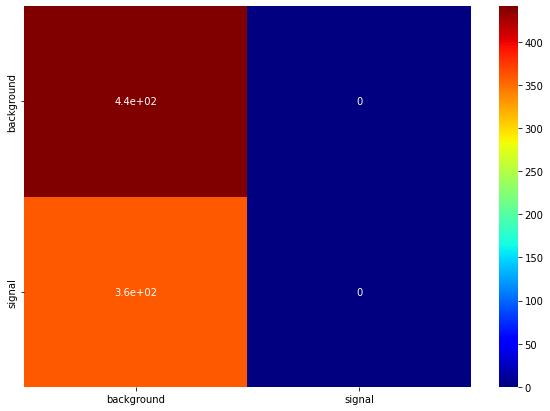

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(reals.flatten(), preds.flatten()), index = ['background', 'signal'],
                  columns = ['background', 'signal'])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.heatmap(df_cm, annot=True, cmap="jet")
plt.show()

# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [ ]:
np.sum(reals.flatten())

359

In [14]:
torch.save(net, './model_save_train_VGG_reduced.pth')

In [9]:
net = torch.load('./model_save_train_VGG_reduced.pth')


In [ ]:
confusion_matrix(reals.flatten(), preds.flatten())

array([[ 45,  12],
       [  8, 335]], dtype=int64)